In [1]:
import pandas as pd
import pickle
pd.set_option('display.max_columns', 55)
pd.set_option('max_colwidth', 100)
pd.set_option('max_rows', 600)

In [2]:
import numpy as np

import itertools
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, fbeta_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, KFold
from sklearn.datasets import make_classification
import seaborn as sns
from sklearn import svm, datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df_data = pd.read_pickle('./data/df_steel_grades.pkl')

In [5]:
X = df_data.iloc[:, :-1].to_numpy()
y = df_data.iloc[:, -1:].to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                        random_state=42)

In [7]:
def kfold_test(model, X_train, y_train, n_val=5, shuffle_val=True, random_val=42, average_val='micro', beta_val = 0.5):
    kf = KFold(n_splits=n_val, shuffle=shuffle_val, random_state=random_val)
    model_results = []
    for train_ind, val_ind in kf.split(X_train,y_train):

        X_train_k, y_train_k = X_train[train_ind], y_train[train_ind]
        X_val, y_val = X_train[val_ind], y_train[val_ind] 

        model.fit(X_train_k, y_train_k)
        model_results.append(fbeta_score(model.predict(X_val), y_val, average=average_val, beta=beta_val))
    return model_results
    

In [8]:
model = LogisticRegression(
penalty='l2',
dual=False,
tol=0.0001,
C=1,
max_iter=100,
multi_class='ovr',    
n_jobs=-1)

### Precision Micro
**Precision** values minimal false positives.  In mfg, rather over spec a product than risk production failure

**Micro** Imbalanced dataset with multiple classes.  Aggregate the contributions of all classes to compute the average metric.

In [9]:
res = kfold_test(model, X_train, y_train, n_val=5, shuffle_val=True, random_val=42)

In [10]:
res

[0.9024390243902438,
 0.8414634146341463,
 0.8780487804878049,
 0.9012345679012345,
 0.8765432098765432]

In [11]:
np.mean(res)

0.8799457994579946

### SMOTE - Synthetic Minority Oversampling TEchnique

In [12]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

Using TensorFlow backend.


In [13]:
from collections import Counter

In [14]:
Counter(y_smoted)

Counter({'Austenitic': 193,
         'Duplex': 193,
         'Ferritic': 193,
         'Superaustenitic': 193,
         'Martensitic': 193})

In [15]:
res_smote = kfold_test(model, X_smoted, y_smoted, n_val=5, shuffle_val=True, random_val=42)

In [16]:
res_smote

[0.9222797927461139,
 0.9222797927461139,
 0.8911917098445595,
 0.9585492227979274,
 0.9222797927461139]

In [17]:
np.mean(res_smote)

0.9233160621761657

### GridSearchCV

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [19]:
from scipy.stats import uniform
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=50)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [20]:
model_results = []
grid_srch = RandomizedSearchCV(model, hyperparameters, n_iter=50, cv=5, scoring='precision_micro', iid=False)
grid_srch.fit(X_smoted, y_smoted)
print(grid_srch.best_score_)
param = grid_srch.best_params_

0.9460998650472335


In [21]:
param

{'C': 43.821468642313995, 'penalty': 'l2'}

### Log Reg with Grid Search Results

In [22]:
model = LogisticRegression(
penalty=param['penalty'],
dual=False,
tol=0.0001,
C=param['C'],
max_iter=100,
multi_class='ovr',    
n_jobs=-1)


In [23]:
gridsearch_res = kfold_test(model, X_smoted, y_smoted, n_val=5, shuffle_val=True, random_val=42)

In [24]:
gridsearch_res

[0.9481865284974094,
 0.9481865284974094,
 0.9326424870466321,
 0.9585492227979274,
 0.9326424870466321]

In [25]:
np.mean(gridsearch_res)

0.944041450777202

In [26]:
model

LogisticRegression(C=43.821468642313995, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

TypeError: '>' not supported between instances of 'str' and 'int'

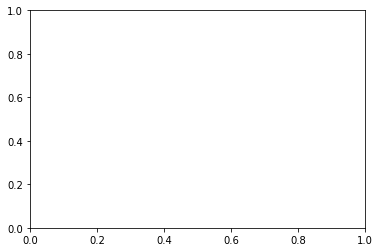

In [27]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.tab10(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
X_lda = LinearDiscriminantAnalysis(n_components=5).fit_transform(X2, y)
plot_embedding(X_lda)


### ROC Curve

In [37]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

ValueError: multiclass format is not supported

In [ ]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))

In [ ]:
# using the new threshold of 0.06
y_predict = (log_reg.predict_proba(X_test)[:,1] > 0.06)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, log_reg.predict_proba(X_test)[:,1] )

plt.figure(dpi=100)

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

In [ ]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, log_reg.predict_proba(X_test))))

### One vs Rest

In [51]:
df_y = pd.DataFrame(y)
df_y = pd.get_dummies(df_y)
y_tr = df_y.to_numpy()
df_y = pd.DataFrame(y_test)
df_y = pd.get_dummies(df_y)
y_te = df_y.to_numpy()

In [52]:
allotrope_lst = [alloy.strip('0_') for alloy in df_y.columns.to_list()]
allotrope_lst

['Austenitic', 'Duplex', 'Ferritic', 'Martensitic', 'Superaustenitic']

In [54]:
for i, alloy in enumerate(allotrope_lst):
    log_reg = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1,
    max_iter=1000,
    n_jobs=-1,
    )
    y_train = y_tr[:,i:i+1]
    y_test = y_te[:,i:i+1]
    log_reg.fit(X_train, y_train)
    print(precision_score(model.predict(X_test), y_test, average='micro'))
    

ValueError: Found input variables with inconsistent numbers of samples: [921, 511]

In [25]:
model = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.0001,
    C=1,
    max_iter=100,
    n_jobs=-1,
)
model.fit(X, y)
recall_score(model.predict(X_test), y_test, average='micro')

0.8620689655172413

In [26]:
def plot_ovr_coefs(model):
    """Helper to plot coefficients of a ovr model like Logistic Regression"""
    n_models, n_coef = model.coef_.shape

    lod = []
    for i in range(n_models):
        for j in range(n_coef):
            lod.append({
                "OVR Model": f"{model.target_names[i]} vs rest",
                "Coefficient Name": f"{model.feature_names[j]}",
                "Coefficient Value": model.coef_[i,j]
            })
    coef_df = pd.DataFrame(lod)
    plt.figure(figsize=(10, 20))
    sns.barplot(y="Coefficient Name", x="Coefficient Value", hue="OVR Model", orient="h", data=coef_df)

In [27]:
feat_names = df_data[:-1].columns.to_list()[:-1]

In [28]:
df_data.allotrope.unique()

array(['Austenitic', 'Ferritic', 'Martensitic', 'Duplex',
       'Superaustenitic'], dtype=object)

In [29]:
log_reg.feature_names = df_data[:-1].columns.to_list()[:-1]
log_reg.target_names = df_data.allotrope.unique()

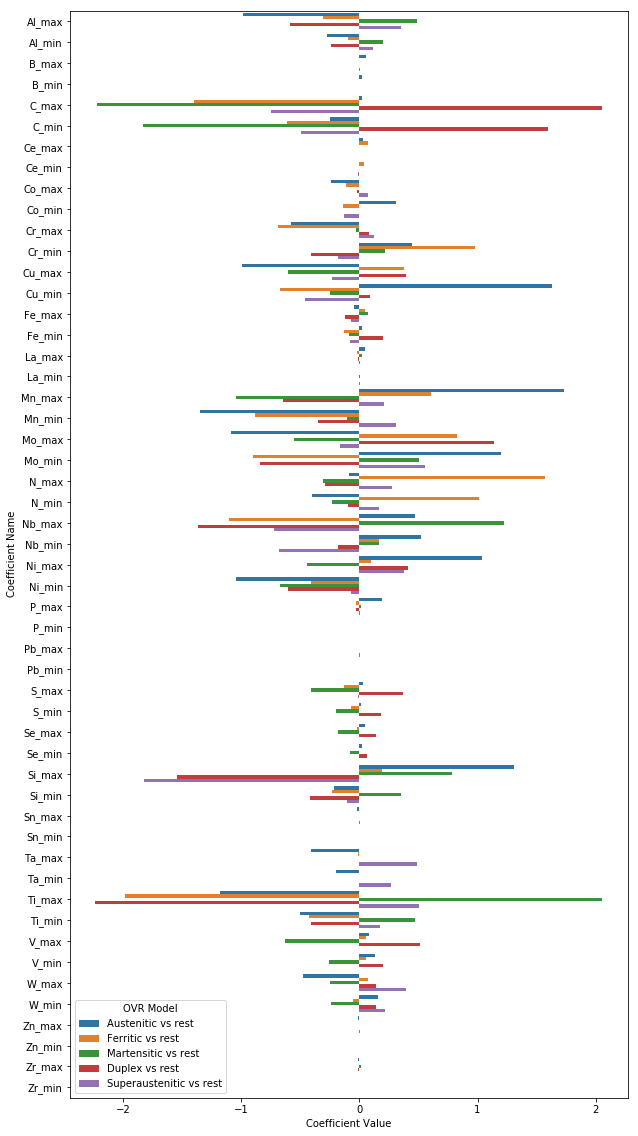

In [30]:
plot_ovr_coefs(log_reg)

In [ ]:
['Austenitic', 'Duplex', 'Ferritic', 'Martensitic', 'Superaustenitic']

In [45]:
coef = model.coef_[0]

In [46]:
from scipy.special import expit

In [47]:
sort_key = [i for i in coef]

In [48]:
feat_names_aus_coef = list(zip(df_data[:-1].columns.to_list()[:-1], coef))

In [49]:
logit_aus = sorted([f for f in feat_names_aus_coef], key=lambda tup: tup[1], reverse=True)

In [50]:
aus_prob = [[n, expit(v)] for n, v in logit_aus]

In [51]:
logit_aus

[('P_max', 169.5190525406036),
 ('La_max', 31.97942648940727),
 ('B_max', 25.9787186185645),
 ('W_min', 9.486043862530172),
 ('V_min', 8.13841362984862),
 ('C_max', 5.384300523914949),
 ('Nb_max', 2.3711628617162734),
 ('Mn_max', 2.358565188546901),
 ('Al_min', 2.1636680603014016),
 ('Cu_min', 2.0630911460528987),
 ('Cr_min', 1.3457412146768923),
 ('Ni_max', 1.0677523512777238),
 ('Si_max', 0.8832135449362897),
 ('Mo_min', 0.6061914281514802),
 ('Si_min', 0.33676480968652395),
 ('S_min', 0.0022228137323104984),
 ('B_min', 0.0),
 ('Co_min', 0.0),
 ('La_min', 0.0),
 ('P_min', 0.0),
 ('Pb_max', 0.0),
 ('Pb_min', 0.0),
 ('Se_max', 0.0),
 ('Se_min', 0.0),
 ('Sn_min', 0.0),
 ('Ta_min', 0.0),
 ('Ti_min', 0.0),
 ('Zn_max', 0.0),
 ('Zn_min', 0.0),
 ('Zr_max', 0.0),
 ('Zr_min', 0.0),
 ('Fe_min', -0.0038680518210603347),
 ('Co_max', -0.00444738800434874),
 ('Fe_max', -0.11910184602589324),
 ('Ce_min', -0.1868818205261149),
 ('Sn_max', -0.38066122875588454),
 ('Mo_max', -0.623915167914116),
 ('Ti_

In [52]:
aus_prob

[['P_max', 1.0],
 ['La_max', 0.9999999999999871],
 ['B_max', 0.9999999999947811],
 ['W_min', 0.9999241019650166],
 ['V_min', 0.9997079850876784],
 ['C_max', 0.995432905619935],
 ['Nb_max', 0.9146017301511276],
 ['Mn_max', 0.9136126307796901],
 ['Al_min', 0.8969391156373167],
 ['Cu_min', 0.8872637377016864],
 ['Cr_min', 0.793432496720946],
 ['Ni_max', 0.7441692402484803],
 ['Si_max', 0.7074877036834544],
 ['Mo_min', 0.6470715266170424],
 ['Si_min', 0.5834044431080221],
 ['S_min', 0.5005557032042715],
 ['B_min', 0.5],
 ['Co_min', 0.5],
 ['La_min', 0.5],
 ['P_min', 0.5],
 ['Pb_max', 0.5],
 ['Pb_min', 0.5],
 ['Se_max', 0.5],
 ['Se_min', 0.5],
 ['Sn_min', 0.5],
 ['Ta_min', 0.5],
 ['Ti_min', 0.5],
 ['Zn_max', 0.5],
 ['Zn_min', 0.5],
 ['Zr_max', 0.5],
 ['Zr_min', 0.5],
 ['Fe_min', 0.499032988250423],
 ['Co_max', 0.49888815483153515],
 ['Fe_max', 0.47025968633271414],
 ['Ce_min', 0.4534150469201378],
 ['Sn_max', 0.4059674266345133],
 ['Mo_max', 0.34889153213476776],
 ['Ti_max', 0.3308095241614